# String processing with Pynini edit transducers

<a href="mailto:kbg@google.com">Kyle Gorman</a> & <a href="mailto:rws@google.com">Richard Sproat</a><br>Google, Inc.<br>111 8th Ave., New York, NY 10011

String _alignment_ and _matching_ are used in bioinformatics, information retrieval, and natural language processing. For example, RNA and DNA bases are aligned to detect mutations, and string matching is used to detect plagiarism, correct spelling mistakes, and provide "translation memories" to assist human translators. Efficient algorithms exist for these problems, but their implementations tend to be complex and use ad hoc designs, limiting code reuse.

In what follows, we describe a data structure called the _edit transducer_ and show how it can be used for string problems. An edit transducer is an abstract data structure&mdash;more specifically, a _weighted finite-state transducer_ (WFST)&mdash;which expresses:

* the ways in which strings may differ from each other, and
* the costs associated with these differences.

An edit transducer and an operation called _composition_ is first used to create a _lattice_&mdash;itself a WFST&mdash;aligning pairs of strings. We then use the lattice to compute the _Levenshtein distance_, a widely-used metric of string similarity, or to build a _Levenshtein automaton_ used to find similar strings.

Our implementation of edit transducers allows users to specify the costs for the various types of edits. For instance, if we're looking for mutations of a gene in a larger genome, we might specify that insertions (i.e, bases present in the genome not matching any of those in the gene) are essentially "free", but deletions (the inverse) have a non-zero cost. Few existing implementations of string algorithms support this. For example, <a href="https://docs.python.org/2/library/difflib.html#difflib.SequenceMatcher">`difflib`</a>, part of the Python core library, implements the textbook algorithm for computing <a href="https://en.wikipedia.org/wiki/Levenshtein_distance">Levenshtein distance</a> (Wagner & Fischer 1974), but it only supports fixed edit costs. The same is true of Python implementations of 
<a href="https://en.wikipedia.org/wiki/Levenshtein_automaton">Levenshtein automaton</a>  (Schulz & Mihov 2002) available <a href="http://blog.notdot.net/2010/07/Damn-Cool-Algorithms-Levenshtein-Automata">here</a> and <a href="http://julesjacobs.github.io/2015/06/17/disqus-levenshtein-simple-and-fast.html">here</a>.

Rather than implementing these algorithms from scratch, we use <a href="http://pynini.opengrm.org">Pynini</a>, a Python library which uses <a href="http://openfst.org">OpenFst</a>, a C++ 11 library for WFSTs, as a backend. Both Pynini and OpenFst were developed at Google for use in speech and language products. These libraries allow us to we delegate the most difficult work to compiled code, carefully tested and extensively optimized, and minimize the risk of programmer error.

In what follows, we provide a brief introduction to finite-state machines (see <a href="https://www.oreilly.com/ideas/how-to-get-superior-text-processing-in-python-with-pynini">here</a> for a gentler, more detailed introduction). Then, we describe the construction of an edit transducer. Finally, we show how the edit transducer can be used to compute Levenshtein distance and implement Levenshtein automata.

Throughout this tutorial, we apply various optimizations to the WFSTs using the `optimize` method and functions like `prune` and `synchronize`. While this produces smaller, more efficient WFSTs, our motivation is primarily pedagogical: optimized WFSTs are usually easier to read and understand. We reserve general discussion of WFST optimization for future work.

Before beginning, we import all the necessary libraries, including Pynini:

In [1]:
from __future__ import division

import string  # Demonstration only.

from pynini import acceptor    # Demonstration only.
from pynini import compose
from pynini import invert
from pynini import isomorphic  # Demonstration only.
from pynini import NO_STATE_ID
from pynini import prune
from pynini import shortestdistance
from pynini import shortestpath
from pynini import string_map
from pynini import synchronize
from pynini import transducer
from pynini import union

## Formal preliminaries

A finite-state machine is an abstract machine whose behavior can be described by transitions between a finite set of states. For instance, a <a href="https://www.oreilly.com/ideas/how-to-get-superior-text-processing-in-python-with-pynini">gumball machine</a> is essentially a two-state machine where the transitions include "inserting a coin",  "turning the knob", and "yielding a gumball". In software, finite-state machines are used to implement regular expression matching. 
A regular expression represents a (possibly infinite) set of strings. Such sets are naturally expressed as a _finite-state acceptor_ (or FSA). Consider the regular expression `ba+`, which matches `ba`, `baa`, `baaa` , and so on. In Pynini, we can express this (somewhat verbosely) as follows:

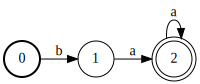

In [2]:
sheep = acceptor("b") + acceptor("a").plus
sheep.optimize(True)

We say that a string matches this regular expression if, by beginning at the start state (here, 0) and taking the appropriate transitions, we can each match the symbols in the string, terminating at the final state (2) once the string has been consumed. For instance, for the string `baaa`, we start in state 0, consume the `b` via transition to state 1, consume the first `a` via transition to state 2, and then consume the remaining `a` symbols via self-transitions at state 2, a final state. However, a single `b` would not match because the path would terminate at state 1, which is not a final state, and `moo` would not match because there is no arc labeled `m` leaving the start state.

_Finite-state transducers_ (FSTs) are a generalization of FSAs which represent the relations between two (possibly infinite) sets of strings. Regular expression substitution (e.g., Python's built-in `re.sub`) can be implemented with FSTs, though the FST formulation is much more expressive. In an FST, each transition is labeled with a pair of (input, output) labels. For instance, the following FST represents the relation `(b:m)(a:o)+`:

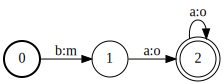

In [3]:
sheep_to_cow = transducer("b", "m") + transducer("a", "o").plus
sheep_to_cow.optimize(True)

If the input here is `baaa`, for example, then we transition from state 0 to 1, 1 to 2, and then 2 to 2 (twice), generating the output string `mooo`.

Finally, a _weighted finite-state transducer_ (WFST) adds weights to the transitions (and final states), so that each pair of strings in the relation has an associated weight. In this tutorial, we use real-valued weights. The _shortest distance_ algorithm is used to find the weight of the lowest-weight path through an WFST; the closely-related _shortest path_ algorithm returns the lowest-weight path(s). In Pynini, all machines are represented as WFSTs; an unweighted FST is simply an WFST where all weights are zero or one, and a FSA is simply a FST where all transitions have the same input and output labels.

## Edit transducers

An edit transducer is a WFST and thus denotes a weighted relation. For simplicity, we assume that this relation has the domain and range $\Sigma^*$ where $\Sigma$ is the _alphabet_. We assume further that each pair of strings in the relation (that is, each _path_) is associated with a non-negative real number weight, and the weight is zero if and only if the input string $s_i$ and the output string $s_o$ are equal.

The edit transducer expresses the various ways in which a string can match, or fail to match, another string drawn from the same alphabet. We decompose this into four character-level operations:

* When an input character and output character are the same, they _match_; e.g., `a` matches `a`
* An output character not present in the input is  _inserted_
* An input character not present in the output is _deleted_
* When an input character and an output character are different, the latter is _substituted_ for the former; e.g., `b` is substituted for `a`

We now proceed to implement these operations as WFSTs.

### Implementing the edit transducer

We implement the match operation using an acceptor representing the (unweighted) union over the alphabet:

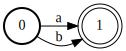

In [4]:
# For simplicity, we assume a two-character alphabet {"a", "b"}.
match = union("a", "b")
match.optimize(True)

Note that an arc labeled `a`, for example, is shorthand for `a:a`.

We implement the insertion operation as a weighted relation from the empty set (here denoted by an empty string) to the above union. Note that when we "insert", the input side arc is labeled `<epsilon>`, a reserved symbol which matches no other symbol:

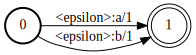

In [5]:
# We use a "1" as a non-zero weight.
insert = transducer("", match, weight=1)
insert.optimize(True)

The deletion operation is implemented by the inverse of the insert operation WFST:

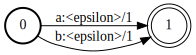

In [6]:
delete = transducer(match, "", weight=1)
# Or, equivalently: delete = invert(insert)
delete.optimize(True)

The substitution operation can be expressed as the cross-product of the alphabet with itself (the `synchronize` function helps to remove unnecessary epsilon arcs). Note that this machine permits self-substitution (i.e., "substituting" a character for itself), which will be optimized away at a later stage:

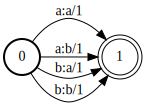

In [7]:
substitute = synchronize(transducer(match, match, weight=1))
substitute.optimize(True)

We now compute the union of these four operations:

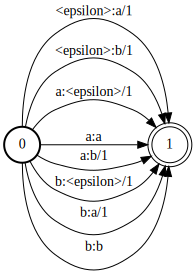

In [8]:
ops = union(match, delete, insert, substitute)
ops.optimize(True)

The `ops` transducer currently only accepts zero or one elements of $\Sigma$, whereas we want a transducer over the infinite set $\Sigma^{*}$. To do this, we compute its (_concatenative_) _closure_:

In [9]:
edit = ops.closure().optimize(True)

### Applying the edit transducer

To "apply" the relation expressed by the edit transducer, we first _compose_ the input string $s_i$ with the left side of the edit transducer. The composition operation is a generalization of set intersection. When we compose an acceptor with the left size of a transducer, we are essentially intersecting the set denoted by the acceptor (here a single string) with the domain of the transducer, producing a WFST denoting a relation from $\{s_i\}$ to $\Sigma^{*}$.

We then compose the resulting transducer with the output string $s_o$. When we compose a the right size of a transducer an acceptor, we are intersecting the set denoted by the range of the transducer with the set denoted by the acceptor (here a single string). This produces a WFST denoting a relation from $\{s_i\}$ to $\{s_o\}$. We refer to this as the _lattice_:

In [10]:
s_i = "abba"
s_o = "baba"

lattice = compose(compose(s_i, edit), s_o)

Every path in this lattice is a possible alignment of the string `abba` to the string `baba`, and the cost of that path is the edit distance for that alignment. when visualizing the lattice, which can be a relatively large WFST, it is sometimes helpful to first "prune" it so that it contains only the optimal paths:

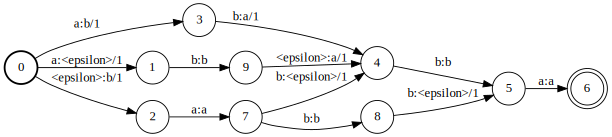

In [11]:
prune(lattice, weight=0)

If we take the path $[0, 3, 4, 5, 6]$, along the top of the graph, we obtain the following alignment, with two matches and two substitutions:

       abba
       baba

If, however, we take the path $[0, 2, 7, 8, 5, 6]$, along the bottom of the graph, we obtain the following alignment, with two matches, one insertion, and one deletion:

       _abba
       bab_a

Both of these paths have the same cost (2) and thus are present in the pruned lattice of optimal paths. Note of course that the optimal pat ths depend on the costs we assign to the different edit operations. If, for instance, we had assigned a zero cost to insertions and a unit cost to deletions and substitution, the former path above would no longer be optimal and the latter path would have a cost of 1.

## Edit transducers for larger vocabularies

The above example used a small (two-symbol) alphabet, as was the resulting transducer. However, the size of the transducer will grow quadratically as a function of the alphabet size. While this is still manageable for the 27 lowercase characters of English or the <a href="https://en.wikipedia.org/wiki/ASCII#Printable_characters">95 printable ASCII characters</a>&mdash;the resulting machine will have 9,215 arcs using the above formulation&mdash;but more than _four billion_ arcs will be needed for the 65,536 code points of the Unicode <a href="https://en.wikipedia.org/wiki/Basic_Multilingual_Plane">Basic Multilingual Plane</a>. This is clearly not feasible.

Fortunately, there is a way to  trick to avoid quadratic growth: we factor the edit transducer into two smaller machines. Above, we computed the lattice $L$ for a pair of strings strings $s_i, s_o$ as follows:

$$L = s_i~\circ~\mathcal{E}~\circ~s_o$$

where $\mathcal{E}$ is the edit transducer and $\circ$ is the composition operator. We factor $\mathcal{E}$ into two smaller transducers $\mathcal{E}_i$ and $\mathcal{E}_o$ such that $\mathcal{E}_i~\circ~\mathcal{E}_o$ is <a href="http://www.openfst.org/twiki/bin/view/FST/IsomorphicDoc">isomorphic</a> to the original $\mathcal{E}$. We can compute a new lattice $L'$ as follows:

$$L' = (s_i~\circ~\mathcal{E}_i)~\circ~(\mathcal{E}_o~\circ~s_o)$$

Because $\mathcal{E}_i~\circ~\mathcal{E}_o$ is isomorphic to $\mathcal{E}$, and 
<a href="https://en.wikipedia.org/wiki/Composition_of_relations">composition is associative</a>, $L$ and $L'$ will also be isomorphic.

Not all regular relations can be factored into two smaller machines, but it is straightforward to do so for the edit transducer above. The basic insight is that instead of enumerating all the possible substitutions (or insertions, or deletions), we treat edits as a two-part process. In the case of substitution, we first map each input symbol to a special `<substition>` symbol in the left factor $\mathcal{E}_i$, and then mapping this special symbol to an output symbol in the right factor $\mathcal{E}_o$. Similar tricks can be applied to the insertion and deletion operations. As a result, the size of the two factors is a linear &mdash;rather than quadratic&mdash;function of alphabet size.

We now proceed to construct the two factors, focusing on the input-side factor $\mathcal{E}_i$ first and then transforming it to generate $\mathcal{E}_o$. For both factors, the match operation is implemented as before: an unweighted union over the alphabet. Note that we halve the costs in $\mathcal{E}_i$ because the cost will also be incurred a second time as the path traverses $\mathcal{E}_o$.

The insert operation maps from epsilon to a reserved symbol `<insert>` with a cost of 1/2:

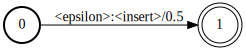

In [12]:
# The square brackets cause the string to be interpreted as a "reserved" symbol.
i_insert = transducer("", "[<insert>]", weight=1/2)
i_insert.optimize(True)

The delete and the substitute operations map from the input alphabet to `<delete>` and to `<substitute>`, respectively, with a cost of 1/2:

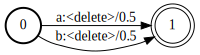

In [13]:
i_delete = transducer(match, "[<delete>]", weight=1/2)
# We have to optimize twice to get the minimal machine.
i_delete.optimize(True).optimize(True)

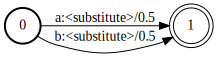

In [14]:
i_substitute = transducer(match, "[<substitute>]", weight=1/2)
# Ditto.
i_substitute.optimize(True).optimize(True)

Then, we put the four left-factor operations together:

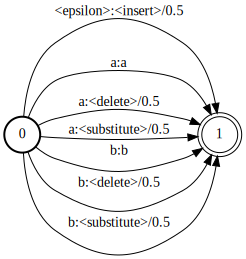

In [15]:
i_ops = union(match, i_insert, i_delete, i_substitute)
i_ops.optimize(True)

For the right factor $\mathcal{E}_o$, we need an insert operation which maps from `<insert>` to the alphabet, a delete operation which maps from `<delete>` to epsilon, and so on. Rather than building these directly, we can construct the entire set of right operations by `invert`ing the left factor and then swapping `<insert>` and `<delete>`  with `relabel_pairs`. This first requires us to look up the integer labels associated with these special symbols:

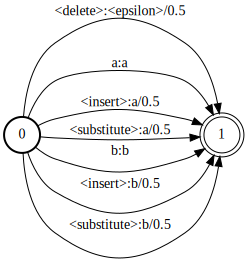

In [16]:
o_ops = invert(i_ops)
syms = o_ops.input_symbols()
insert_label = syms.find("<insert>")
delete_label = syms.find("<delete>")
o_ops.relabel_pairs(ipairs=((insert_label, delete_label),
                                   (delete_label, insert_label)))

Finally, we compute the closures of the two sets of operations and optimize:

In [17]:
e_i = i_ops.closure().optimize(True)
e_o = o_ops.closure().optimize(True)

Just to be sure, let's confirm that the composition of the two factors is in fact isomorphic to the single-machine edit transducer:

In [18]:
factored_edit = compose(e_i, e_o)
factored_edit.optimize(True)
assert isomorphic(edit, factored_edit)

And, as we can see below, this construction produced a pruned lattice isomorphic to the one above:

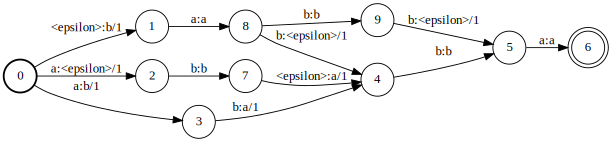

In [19]:
i_edit = compose(s_i, e_i)
o_edit = compose(e_o, s_o)
prune(compose(i_edit, o_edit), weight=0)

We now proceed to wrap this into a class called `EditTransducer`. We expose the following parameters to the user:
    
* the alphabet (an iterable of strings)
* the cost of insertion (defaulting to 1)
* the cost of deletion (defaulting to 1)
* the cost of substitution (defaulting to 1)

In addition to a constructor which builds the two factors, we add a method which builds the lattice for a pair of strings, and a static method which checks that a lattice is well-formed (i.e., has a valid start state). If the lattice is illformed, this indicates that one or more characters in the input and/or output string is not in the provided alphabet. Since most operations will be undefined in this case, an exception is thrown. This class is given below:

In [20]:
DEFAULT_INSERT_COST = 1
DEFAULT_DELETE_COST = 1
DEFAULT_SUBSTITUTE_COST = 1


class LatticeError(Exception):
  pass


class EditTransducer(object):
  """Factored edit transducer.
  
  This class stores the two factors of an finite-alphabet edit transducer and
  supports insertion, deletion, and substitution operations with user-specified
  costs.

  Note that the cost of substitution must be less than the cost of insertion
  plus the cost of deletion or no optimal path will include substitution.
  """

  # Reserved labels for edit operations.
  DELETE = "<delete>"
  INSERT = "<insert>"
  SUBSTITUTE = "<substitute>"

  def __init__(self,
               alphabet,
               insert_cost=DEFAULT_INSERT_COST,
               delete_cost=DEFAULT_DELETE_COST,
               substitute_cost=DEFAULT_SUBSTITUTE_COST):
    """Constructor.

    Args:
      alphabet: edit alphabet (an iterable of strings).
      insert_cost: the cost for the insertion operation.
      delete_cost: the cost for the deletion operation.
      substitute_cost: the cost for the substitution operation.
    """
    # Left factor; note that we divide the edit costs by two because they also
    # will be incurred when traversing the right factor.
    match = union(*alphabet).optimize(True)
    i_insert = transducer("", "[{}]".format(self.INSERT),
                          weight=insert_cost / 2).optimize(True)
    i_delete = transducer(match, "[{}]".format(self.DELETE),
                          weight=delete_cost / 2).optimize(True)
    i_substitute = transducer(match, "[{}]".format(self.SUBSTITUTE),
                              weight=substitute_cost / 2).optimize(True)
    i_ops = union(match, i_insert, i_delete, i_substitute).optimize(True)
    # Right factor; this is constructed by inverting the left factor (i.e.,
    # swapping the input and output labels), then swapping the insert and delete
    # labels on what is now the input side.
    o_ops = invert(i_ops)
    syms = o_ops.input_symbols()
    insert_label = syms.find(self.INSERT)
    delete_label = syms.find(self.DELETE)
    o_ops.relabel_pairs(ipairs=((insert_label, delete_label),
                                (delete_label, insert_label)))
    # Computes the closure for both sets of ops.
    self._e_i = i_ops.closure().optimize(True)
    self._e_o = o_ops.closure().optimize(True)
  
  @staticmethod
  def check_wellformed_lattice(lattice):
    """Raises an error if the lattice is empty.

    Args:
      lattice: A lattice FST.

    Raises:
      LatticeError: Lattice is empty.
    """
    if lattice.start() == NO_STATE_ID:
      raise LatticeError("Lattice is empty")

  def _create_lattice(self, iset, oset):
    """Creates edit lattice for a pair of input/output strings or acceptors.

    Args:
      iset: input string or acceptor
      oset: output string or acceptor.

    Returns:
      A lattice FST.
    """
    l_i = compose(iset, self._e_i)
    l_o = compose(self._e_o, oset)
    lattice = compose(l_i, l_o)
    EditTransducer.check_wellformed_lattice(lattice)
    return lattice

## From edit transducers to Levenshtein distance

The above class constructs the two factors of the edit transducer, and then applies them to input/output strings or sets to create the lattice. But the lattice does not direclty measure the similarity of the input and output string. To compute that, we compute the _shortest distance_ from all final state to the start state&mdash;the cost of the shortest path through the lattice. With default weights, this will simply be the minimal number of insertions, deletions, and substitutions needed to align the two strings; this metric is known as _Levenshtein distance_. We implement this below by deriving a new class, `LevenshteinDistance`, from the `EditTransducer` base class:

In [21]:
class LevenshteinDistance(EditTransducer):
  """Edit transducer augmented with a distance calculator."""

  def distance(self, iset, oset):
    """Computes minimum distance.

    This method computes, for a pair of input/output strings or acceptors, the
    minimum edit distance according to the underlying edit transducer.

    Args:
      iset: input string or acceptor.
      oset: output string or acceptor.

    Returns:
      Minimum edit distance according to the edit transducer.
    """
    lattice = self._create_lattice(iset, oset)
    start_state = lattice.start()
    # The shortest cost from all final states to the start state is
    # equivalent to the cost of the shortest path.
    return float(shortestdistance(lattice, reverse=True)[start_state])

The following example shows computation of edit distance for the strings `abba`, `baba`, which as we saw above, is `2.0` using the default costs.

In [22]:
ld = LevenshteinDistance(("a", "b"))
assert ld.distance(s_i, s_o) == 2.0

## From Levenshtein distance to Levenshtein automata

Imagine we have a query string and wish to find the string or strings in a fixed _lexicon_ it is closest to, in terms of edit distance. This problem arises in many applications, including search and spelling correction. Naïvely, we could simply use `LevenshteinDistance` to compute the distance between the query and each word in the lexicon, though this approach scales very poorly. Schulz & Mihov (2002) describe an efficient alternative using a _Levenshtein automaton_. Now, quite a bit of ink has been spilled trying to
<a href="http://blog.mikemccandless.com/2011/03/lucenes-fuzzyquery-is-100-times-faster.html">understand Schulz & Mihov's paper</a>, but their idea is a straighforward extension of our `EditTransducer` base class.

Like an edit transducer, a Levenshtein automaton is a WFST representing a weighted relation over sets of strings in which domain of this relation is $\Sigma^{*}$. However, in a Levenshtein automaton, the range is a subset thereof defined by a fixed, user-specified _lexicon_, a finite set of strings. The relation itself is specified by an edit transducer. Therefore, if we compose an input string with the Levenshtein transducer and prune all non-optimal paths, we obtain a lattice representing the alignment of the input string to all of the "closest" strings in the lexicon (according to the edit distance).

Using the two-factor edit transducer above, we can implement first this by compiling the lexicon into an FSA using Pynini's `string_map` function, which constructs the finite-state equivalent of a <a href="https://en.wikipedia.org/wiki/Trie">prefix tree</a>:

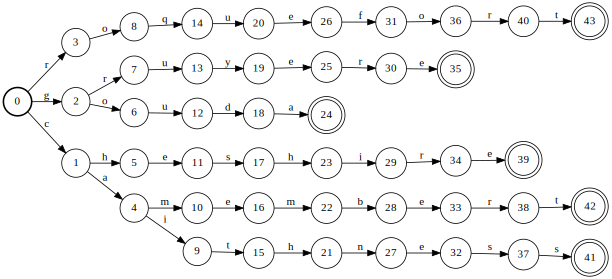

In [23]:
lexicon = ("gruyere", "cheshire", "roquefort",
           "camembert", "gouda", "caithness")
compiled_lexicon = string_map(lexicon)
compiled_lexicon

We can then use this machine in place of $s_o$, the output-side string used to construct the lattice. Recall that the full two-factor lattice for two pairs of strings $s_i$ and $s_o$ was given by:

$$L' = (s_i~\circ~\mathcal{E}_i)~\circ~(\mathcal{E}_o~\circ~s_o)$$

In a Levenshtein transducer, we simply replace $s_o$ with a lexicon acceptor. Assuming the lexicon is fixed, it is not necessary to recompute the $\mathcal{E}_o~\circ~s_o$ term; instead, we compiling the lexicon and composing the right-hand side of the right factor with it, and then store the result for reuse. Once we have computed the lattice $L'$, it is straightforward to compute the Levenshtein distance to the nearest element(s) in the lexicon. Pynini's `shortestpath` function can be used to compute (one of) the nearest strings in the lexicon. To obtain all of the closest strings, we simply prune the lattice of all suboptimal paths, optimize, and then enumerate the strings in the pruned lattice.
This is accomplished below by deriving a new class, `LevenshteinDistance`, from `LevenshteinDistance`:

In [24]:
class LevenshteinAutomaton(LevenshteinDistance):
  """Edit transducer with a fixed output lexicon and closest-match methods."""

  def __init__(self,
               alphabet,
               lexicon,
               insert_cost=DEFAULT_INSERT_COST,
               delete_cost=DEFAULT_DELETE_COST,
               substitute_cost=DEFAULT_SUBSTITUTE_COST):
    super(LevenshteinAutomaton, self).__init__(alphabet, insert_cost,
                                               delete_cost, substitute_cost)
    # Compiles lexicon and composes the right factor with it.
    compiled_lexicon = string_map(lexicon)
    self._l_o = compose(self._e_o, compiled_lexicon)
    self._l_o.optimize(True)

  def _create_levenshtein_automaton_lattice(self, query):
    """Constructs a lattice for a query string.

    Args:
      query: input string or acceptor.

    Returns:
      A lattice FST.
    """
    l_i = compose(query, self._e_i)
    lattice = compose(l_i, self._l_o)
    EditTransducer.check_wellformed_lattice(lattice)
    return lattice

  def closest_match(self, query):
    """Returns the closest string to the query in the lexicon.

    This method computes, for an input string or acceptor, the closest string
    in the lexicon according to the underlying edit transducer. In the case of
    a tie (i.e., where there are multiple closest strings), only one will be
    returned; tie breaking is deterministic but difficult to reason about and
    thus should be considered unspecified.) The `closest_matches` method can be
    used to enumerate all the ties.

    Args:
      query: input string or acceptor.

    Returns:
      The closest string in the lexicon.
    """
    lattice = self._create_levenshtein_automaton_lattice(query)
    # For implementation reasons, the shortest path (when k = 1) is in reverse
    # state order, so we perform a topological sort ahead of time.
    return shortestpath(lattice).topsort().stringify()

  def closest_matches(self, query):
    """Returns all of the closest strings to the query in the lexicon.

    This method returns, for an input string or acceptor, the closest strings
    in the lexicon according to the underlying edit transducer. A string is
    "closest" if it has the same edit distance as the closest string. The order
    in which the strings are returned is deterministic but difficult to reason
    about and thus should be considered unspecified.

    Args:
      query: input string or acceptor.

    Returns:
      An iterator of the closest strings in the lexicon.
    """
    lattice = self._create_levenshtein_automaton_lattice(query)
    # Prunes all paths whose weights are worse than the best path.
    lattice.prune(weight=0).project(True).optimize(True)
    return lattice.paths().iter_ostrings()

The following example shows the Levenshtein automaton in action:

In [25]:
la = LevenshteinAutomaton(string.ascii_lowercase, lexicon)
assert la.closest_match("rockford") == "roquefort"
assert next(la.closest_matches("cheesesure")) == "cheshire"

## Possible extensions

We have made the above code available as <a href="http://github.com/kylebgorman/EditTransducer">EditTransducer</a>, an MIT-licensed Python library, and encourage readers to tinker with it. Here are several possible extensions, which we leave as exercises for the reader:

* The edit transducer could be made to output the optimal alignments, to help users visualize the process.
* Currently, the edit transducer assigns the same cost to all insertions, to all deletions, and to all substitutions, respectively. However, one could also make it possible to vary the costs depending on the input and/or outputs. For instance, if we are attempting to expand abbreviations like `mtn` to full words like `mountain`, we might make insertion of vowels cheaper than that of consonants.
* In some applications, especially computational genomics, it is considered desirable to use an <a href="https://en.wikipedia.org/wiki/Gap_penalty#Affine">_affine gap penalty_</a> assigning separate costs for "opening" a gap&mdash;i.e., starting a sequence of insertions or deletions&mdash;and for "continuing" the gap&mdash;i.e., for each insertion and deletion in the "gap". The edit transducer could be extended to support affine gap penalties.
* <a href="http://norvig.com/spell-correct.html">This blog post</a> describes a spelling correction system which essentially consists of a limited form of a Levenshtein automaton (the implementation only supports two or fewer edits); in the case that there is more than one closest match in the lexicon, it selects the word with the highest frequency according to some user-provided corpus. `LevenshteinAutomaton` could be extended in various ways so as to support word-frequency-based tie-breaking.
* When we compose strings with the edit transducer factors, the strings are first implicitly compiled as FSAs where each arc is a byte in the input string; as is the default in Pynini, strings are assumed to be UTF-8 encoded unless otherwise specified. Thus when we compute the edit distance, we are computing it by comparing the underlying bytes between the input and output strings. However, Pynini also supports an
alternative modes of string compilation, including one in which <a href="http://openfst.cs.nyu.edu/twiki/bin/view/GRM/PyniniStringDoc">each label is a Unicode codepoint</a>). This may be more appropriate for languages where glyphs are multibyte sequences. This mode could be optionally enabled in the constructor of `EditTransducer` and `LevenshteinAutomaton` and then used when compiling the lattice (and in the case of `LevenshteinAutomaton`, when compiling the lexicon).

## Conclusions

We have shown how to construct an edit transducer and to use it for computing edit distance and approximate string. The edit transducer formulation of these (and related) problems is efficient: composition with the factored edit transducer is linear in the size of the input strings or sets, and the shortest distance and path computations are quadratic in the size of the lattice. They are also expressive in that they support user-defined costs and could be extended to support arbitrary edit operations. Finally, by implementing these algorithms using generic finite-state operations, we delegate much of the difficult work to compiled code, carefully tested and extensively optimized, exposed by Pynini.

## References

Gorman, K. 2016. Pynini: A Python library weighted finite-state grammar compilation.
In _Proceedings of the ACL Workshop on Statistical NLP and Weighted Automata_, pages 75-80.

Schulz, K., and Mihov, S. 2002. Fast string correction with Levenshtein-automata.
_International Journal of Document Analysis and Recognition_ 5(1): 67-85.

Wagner, R. A., and Fischer, M. J. 1974. The string-to-string correction problem.
_Journal of the ACM_ 21(1): 168-173.